In [2]:
from torch_geometric.datasets import Planetoid, PPI
from torch_geometric.data import Batch
from torch_geometric.loader import NeighborLoader, DataLoader
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GraphSAGE
from sklearn.metrics import f1_score

torch.manual_seed(-1)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
pubmed_dataset = Planetoid(root='../data//Pubmed', name='Pubmed')
print(f'Dataset: {pubmed_dataset}')
print(f'Number of graphs: {len(pubmed_dataset)}')
print(f'Number of nodes: {pubmed_dataset[0].x.shape[0]}')
print(f'Number of node features: {pubmed_dataset.num_node_features}')
print(f'Number of classes: {pubmed_dataset.num_classes}')
print(f'Number of training nodes: {pubmed_dataset[0].train_mask.sum()}')

print('Graph:')
print(f'Training nodes: {pubmed_dataset[0].train_mask.sum()}')
print(f'Validation nodes: {pubmed_dataset[0].val_mask.sum()}')
print(f'Test nodes: {pubmed_dataset[0].test_mask.sum()}')
print(f'Edges are directed: {pubmed_dataset[0].is_directed()}')
print(f'Graph has Isolated Nodes: {pubmed_dataset[0].has_isolated_nodes()}')
print(f'Graph has Self Loops: {pubmed_dataset[0].has_self_loops()}')

Dataset: Pubmed()
Number of graphs: 1
Number of nodes: 19717
Number of node features: 500
Number of classes: 3
Number of training nodes: 60
Graph:
Training nodes: 60
Validation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has Isolated Nodes: False
Graph has Self Loops: False


In [4]:
train_loader = NeighborLoader(
    pubmed_dataset[0],
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=pubmed_dataset[0].train_mask,
    shuffle=False
)

for i, sub_graph in enumerate(train_loader):
    print(f'Subgraph {i}:{sub_graph}')


Subgraph 0:Data(x=[383, 500], edge_index=[2, 441], y=[383], train_mask=[383], val_mask=[383], test_mask=[383], n_id=[383], e_id=[441], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[16], batch_size=16)
Subgraph 1:Data(x=[251, 500], edge_index=[2, 302], y=[251], train_mask=[251], val_mask=[251], test_mask=[251], n_id=[251], e_id=[302], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[16], batch_size=16)
Subgraph 2:Data(x=[295, 500], edge_index=[2, 337], y=[295], train_mask=[295], val_mask=[295], test_mask=[295], n_id=[295], e_id=[337], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[16], batch_size=16)
Subgraph 3:Data(x=[184, 500], edge_index=[2, 223], y=[184], train_mask=[184], val_mask=[184], test_mask=[184], n_id=[184], e_id=[223], num_sampled_nodes=[3], num_sampled_edges=[2], input_id=[12], batch_size=12)


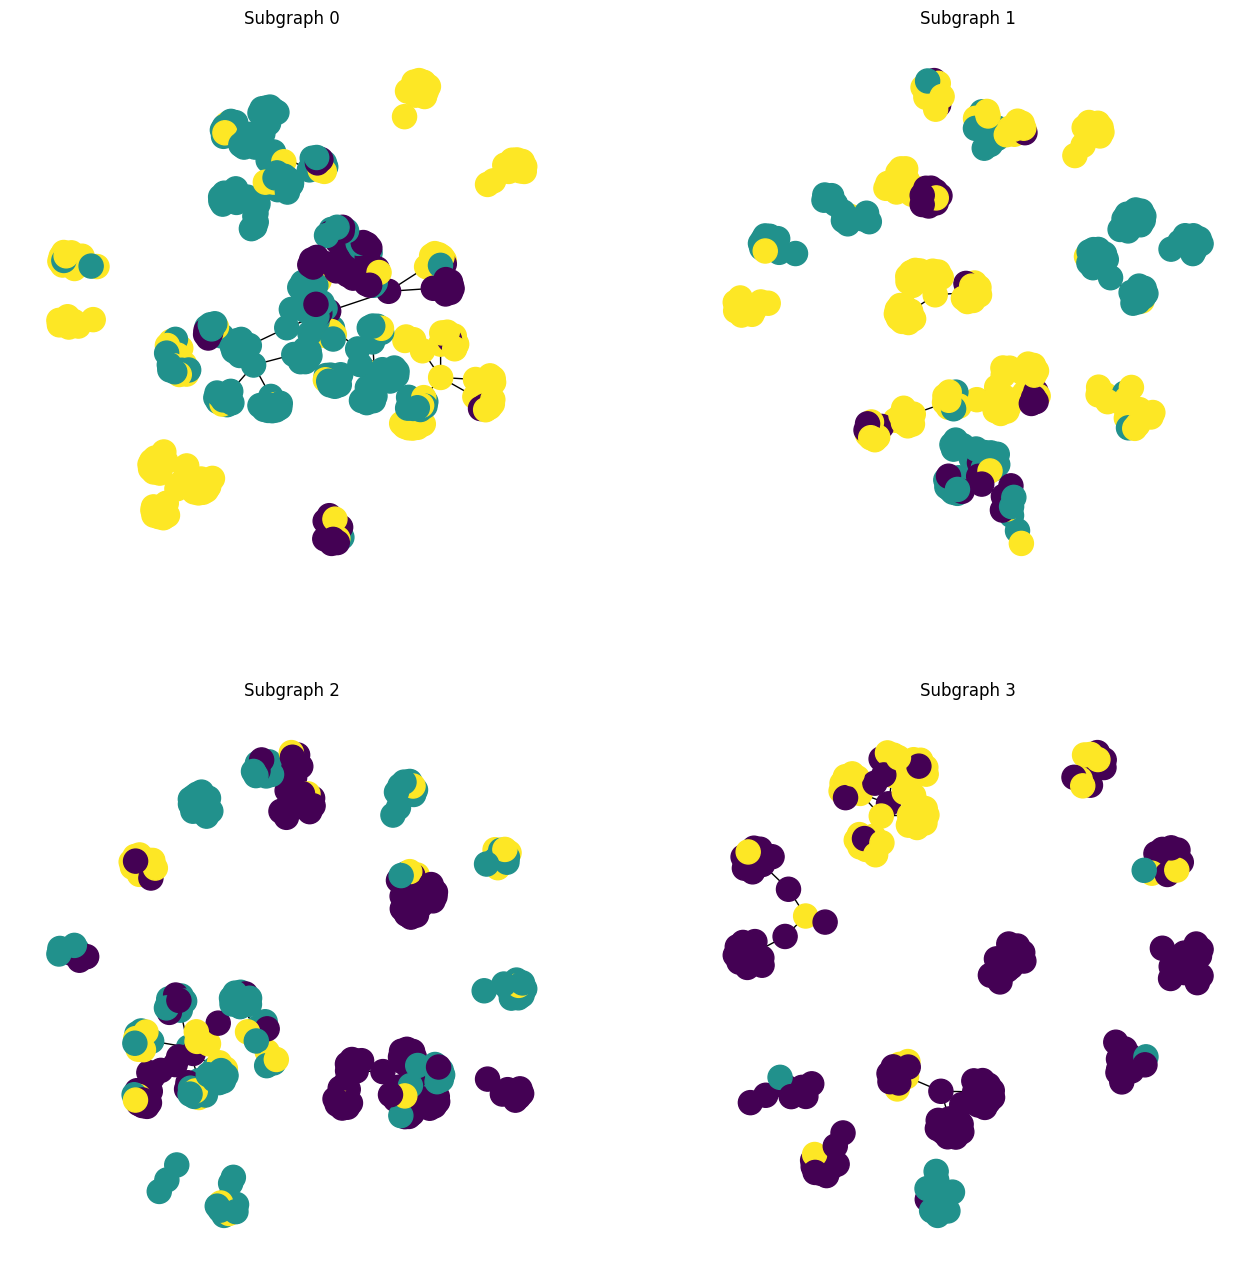

In [5]:
fig = plt.figure(figsize=(16, 16))
for idx, (sub_data, pos) in enumerate(zip(train_loader, range(221, 225))):
    G = to_networkx(sub_data, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}')
    plt.axis('off')
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=0), with_labels=False ,node_color=sub_data.y)
plt.show()

In [6]:
class GraphSAGE_model(torch.nn.Module):
    def __init__(self, dim_in,dim_h, dim_out):
        super(GraphSAGE_model, self).__init__()
        self.sage1 = SAGEConv(dim_in, dim_h)
        self.sage2 = SAGEConv(dim_h, dim_out)
    
    def accuracy(self, pred, labels):
        pred = pred.argmax(dim=1)
        correct = (pred == labels).sum().item()
        acc = correct / len(labels)
        return acc
    def forward(self, x, edge_index):
        h = self.sage1(x, edge_index)
        h = F.relu(h)
        h = F.dropout(h,p = 0.5, training=self.training)
        h = self.sage2(h, edge_index)
        return F.log_softmax(h, dim=1)
    
    def fit(self, data, epochs=100):
        criterion = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        self.train()
        for epoch in range(epochs+1):
            train_loss, val_loss, train_acc, val_acc = 0, 0 , 0 , 0
            for batch in train_loader:
                optimizer.zero_grad()
                out = self(batch.x, batch.edge_index)
                loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
                train_loss += loss
                train_acc += self.accuracy(out[batch.train_mask], batch.y[batch.train_mask])
                val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask]).item()
                loss.backward()
                optimizer.step()
                val_acc += self.accuracy(out[batch.val_mask], batch.y[batch.val_mask])
            if epoch % 20 == 0:
                print(f'Epoch {epoch}, Loss: {loss.item():.4f}, '
                        f'Train Acc: {train_acc/len(train_loader):.4f}, '
                        f'Val Acc: {val_acc/len(train_loader):.4f}')
    @torch.no_grad()
    
    def test(self, data):
        self.eval()
        out = self(data.x, data.edge_index)
        test_loss = F.cross_entropy(out[data.test_mask], data.y[data.test_mask])
        test_acc = self.accuracy(out[data.test_mask], data.y[data.test_mask])
        return test_loss, test_acc
    




In [7]:
graphsage = GraphSAGE_model(pubmed_dataset.num_node_features, 64, pubmed_dataset.num_classes)
print(graphsage)
graphsage.fit(pubmed_dataset[0], epochs=200)
test_loss, test_acc = graphsage.test(pubmed_dataset[0])
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

GraphSAGE_model(
  (sage1): SAGEConv(500, 64, aggr=mean)
  (sage2): SAGEConv(64, 3, aggr=mean)
)
Epoch 0, Loss: 1.1123, Train Acc: 0.1949, Val Acc: 0.2868
Epoch 20, Loss: 0.0099, Train Acc: 1.0000, Val Acc: 0.8167
Epoch 40, Loss: 0.0006, Train Acc: 1.0000, Val Acc: 0.8368
Epoch 60, Loss: 0.0010, Train Acc: 1.0000, Val Acc: 0.8354
Epoch 80, Loss: 0.0003, Train Acc: 1.0000, Val Acc: 0.6500
Epoch 100, Loss: 0.0003, Train Acc: 1.0000, Val Acc: 0.7514
Epoch 120, Loss: 0.0001, Train Acc: 1.0000, Val Acc: 0.7708
Epoch 140, Loss: 0.0001, Train Acc: 1.0000, Val Acc: 0.8958
Epoch 160, Loss: 0.0001, Train Acc: 1.0000, Val Acc: 0.7750
Epoch 180, Loss: 0.0000, Train Acc: 1.0000, Val Acc: 0.8008
Epoch 200, Loss: 0.0000, Train Acc: 1.0000, Val Acc: 0.7479
Test Loss: 1.1425, Test Acc: 0.7540


In [ ]:
train_dataset = PPI(root='../data/PPI', split='train')
val_dataset = PPI(root='../data/PPI', split='val')
test_dataset = PPI(root='../data/PPI', split='test')

train_data = Batch.from_data_list(train_dataset)
loader = NeighborLoader(
    train_data,
    num_neighbors=[20, 10],
    batch_size=2048,
    num_workers=2,
    shuffle=True,
    persistent_workers=True
)
train_loader = DataLoader(train_dataset, batch_size=2)
val_loader = DataLoader(val_dataset, batch_size=2)
test_loader = DataLoader(test_dataset, batch_size=2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GraphSAGE(
    in_channels=train_dataset.num_features,
    hidden_channels=512,
    out_channels=train_dataset.num_classes,
    num_layers=2,
).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
def fit():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = criterion(out, batch.y)
        total_loss += loss.item() * batch.num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)

@torch.no_grad()
def test(loader):
    model.eval()
    data = next(iter(loader))
    out = model(data.x.to(device), data.edge_index.to(device))
    preds  = (out > 0).float().cpu()
    y, preds = data.y.numpy(), preds.numpy()
    f1 = f1_score(y, preds, average='macro') if preds.sum() > 0 else 0
    return f1

for epoch in range(1, 301):
    loss = fit()
    val_f1 = test(val_loader)
    if epoch % 50 == 0:
        print(f'Epoch {epoch},Train Loss: {loss:.4f}, 'f'Val F1: {val_f1:.4f}')

print(f'Test F1: {test(test_loader):.4f}')


Epoch 50,Train Loss: 0.1907, Val F1: 0.8069
Epoch 100,Train Loss: 0.1419, Val F1: 0.8552
Epoch 150,Train Loss: 0.1196, Val F1: 0.8762
Epoch 200,Train Loss: 0.1057, Val F1: 0.8899
Epoch 250,Train Loss: 0.0966, Val F1: 0.8958
Epoch 300,Train Loss: 0.0873, Val F1: 0.9033
Test F1: 0.9267
Test Loss: 0.9267
